# Employee Salary Analysis and Visualization using Python

Developer-style, GitHub-ready notebook. This notebook performs data loading, cleaning, exploratory data analysis, statistical testing (ANOVA), visualizations, and includes extra practice sections such as predictive modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style='whitegrid', palette='muted')
%matplotlib inline

## Load data

Load the dataset from the notebook environment. The file name expected in the working directory is **employee_salary_data.csv**.

In [4]:
df=pd.read_csv(r"C:\Users\User\Downloads\employee_salary_data.csv")
df.head()

,Employee_ID,Age,Gender,Education_Level,Work_Experience,Job_Title,Department,Monthly_Salary,Performance_Score,Remote_Work_Percentage,City
0,1001,50,Male,Bachelor,9,Manager,Marketing,80000.0,8,25,Nakuru
1,1002,36,Female,Bachelor,16,Data Scientist,Operations,69000.0,9,25,Eldoret
2,1003,29,Female,Bachelor,9,Analyst,Marketing,48000.0,3,0,Kisumu
3,1004,42,Female,Bachelor,16,Consultant,Finance,91000.0,10,0,Kisumu
4,1005,40,Female,Bachelor,19,Manager,Finance,64000.0,3,25,Nairobi


## Quick inspection

Check shape, dtypes, missing values, and a concise summary.

In [5]:
print('Shape:', df.shape)
print('\nData types:')
print(df.dtypes)

print('\nMissing values per column:')
print(df.isnull().sum())

print('\nDuplicate rows:', df.duplicated().sum())

Shape: (200, 11)

Data types:
Employee_ID                 int64
Age                         int64
Gender                     object
Education_Level            object
Work_Experience             int64
Job_Title                  object
Department                 object
Monthly_Salary            float64
Performance_Score           int64
Remote_Work_Percentage      int64
City                       object
dtype: object

Missing values per column:
Employee_ID               0
Age                       0
Gender                    0
Education_Level           0
Work_Experience           0
Job_Title                 0
Department                0
Monthly_Salary            0
Performance_Score         0
Remote_Work_Percentage    0
City                      0
dtype: int64

Duplicate rows: 0


## Data cleaning

- Drop exact duplicate rows
- Handle obvious inconsistent column names (strip spaces)
- Basic type conversions


In [6]:
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f'Dropped {initial_rows - df.shape[0]} duplicate rows')

for col in ['Monthly_Salary', 'Work_Experience', 'Age', 'Performance_Score']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


df.info()

Dropped 0 duplicate rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employee_ID             200 non-null    int64  
 1   Age                     200 non-null    int64  
 2   Gender                  200 non-null    object 
 3   Education_Level         200 non-null    object 
 4   Work_Experience         200 non-null    int64  
 5   Job_Title               200 non-null    object 
 6   Department              200 non-null    object 
 7   Monthly_Salary          200 non-null    float64
 8   Performance_Score       200 non-null    int64  
 9   Remote_Work_Percentage  200 non-null    int64  
 10  City                    200 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 17.3+ KB


## Summary statistics

Numeric summary for quick reference.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Employee_ID,200.0,1100.50,57.879185,1001.0,1050.75,1100.5,1150.25,1200.0
Age,200.0,40.17,11.242020,22.0,30.00,41.0,49.00,59.0
Work_Experience,200.0,18.36,11.657180,0.0,8.00,18.0,28.25,39.0
Monthly_Salary,200.0,81770.00,18635.005154,38000.0,69000.00,81000.0,94000.00,131000.0
Performance_Score,200.0,5.39,2.908642,1.0,3.00,5.0,8.00,10.0
Remote_Work_Percentage,200.0,23.00,28.173012,0.0,0.00,25.0,50.00,100.0


## Encode categorical variables

- Order Education_Level (Diploma → Bachelor's → Master's → PhD)
- Create dummies for selected categorical columns (drop_first=True to avoid multicollinearity in some models).

In [8]:
edu_order = ['Diploma', "Bachelor's", "Master's", 'PhD']
if 'Education_Level' in df.columns:
    df['Education_Level'] = pd.Categorical(df['Education_Level'].astype(str).replace({'Bachelors':"Bachelor's", 'Masters':"Master's"}),
                                           categories=edu_order, ordered=True)

cat_cols = [c for c in ['Job_Title','Education_Level','Department','Gender','City'] if c in df.columns]
print('Categorical columns:', cat_cols)

df_encoded = pd.get_dummies(df, columns=[c for c in cat_cols if c!='Education_Level'], drop_first=True)
if 'Education_Level' in df.columns:
    df_encoded['Education_Level_Code'] = df['Education_Level'].cat.codes

df_encoded.head()

Categorical columns: ['Job_Title', 'Education_Level', 'Department', 'Gender', 'City']


,Employee_ID,Age,Education_Level,Work_Experience,Monthly_Salary,Performance_Score,Remote_Work_Percentage,Job_Title_Consultant,Job_Title_Data Scientist,Job_Title_Engineer,...,Department_IT,Department_Marketing,Department_Operations,Gender_Male,Gender_Other,City_Kisumu,City_Mombasa,City_Nairobi,City_Nakuru,Education_Level_Code
0,1001,50,NaN,9,80000.0,8,25,False,False,False,...,False,True,False,True,False,False,False,False,True,-1
1,1002,36,NaN,16,69000.0,9,25,False,True,False,...,False,False,True,False,False,False,False,False,False,-1
2,1003,29,NaN,9,48000.0,3,0,False,False,False,...,False,True,False,False,False,True,False,False,False,-1
3,1004,42,NaN,16,91000.0,10,0,True,False,False,...,False,False,False,False,False,True,False,False,False,-1
4,1005,40,NaN,19,64000.0,3,25,False,False,False,...,False,False,False,False,False,False,False,True,False,-1


## Outliers in Monthly_Salary

Detect outliers using IQR and create a version with outliers removed for sensitivity analysis.

In [9]:
if 'Monthly_Salary' in df.columns:
    s = df['Monthly_Salary'].dropna()
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df['Monthly_Salary'] < lower) | (df['Monthly_Salary'] > upper)]
    print('Detected outliers:', outliers.shape[0])
    df_no_outliers = df[(df['Monthly_Salary'] >= lower) & (df['Monthly_Salary'] <= upper)].copy()
    print('Rows after removing outliers:', df_no_outliers.shape[0])
else:
    print('Monthly_Salary column not found')

Detected outliers: 0
Rows after removing outliers: 200


## Average salary per department

Bar chart and pie chart for average monthly salary by department.

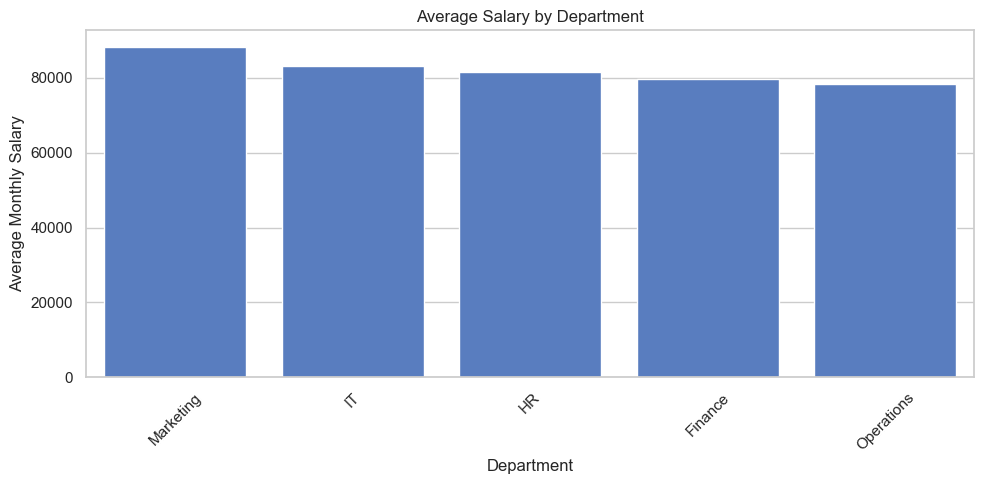

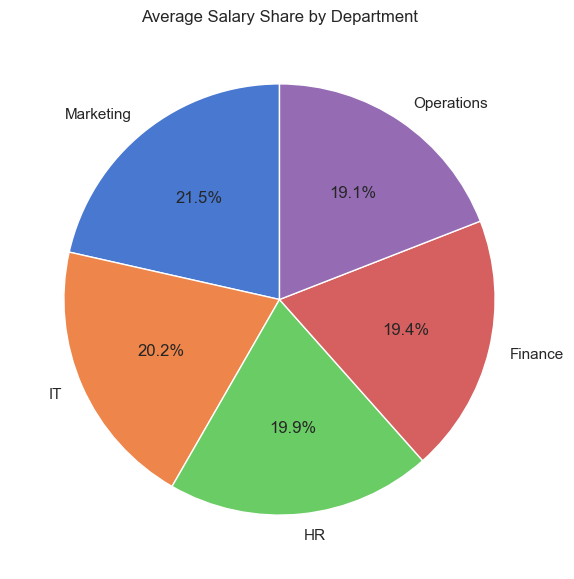

In [10]:
if 'Department' in df.columns and 'Monthly_Salary' in df.columns:
    avg_by_dept = df.groupby('Department')['Monthly_Salary'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(x=avg_by_dept.index, y=avg_by_dept.values)
    plt.xticks(rotation=45)
    plt.ylabel('Average Monthly Salary')
    plt.title('Average Salary by Department')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,7))
    avg_by_dept.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.ylabel('')
    plt.title('Average Salary Share by Department')
    plt.show()
else:
    print('Department or Monthly_Salary column missing')

## Education level effect

Line plot of average salary (ordered) and boxplot for distribution.

C:\Users\User\AppData\Local\Temp\ipykernel_13288\2158827080.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_salary_edu = df.groupby('Education_Level')['Monthly_Salary'].mean().reindex(edu_order)


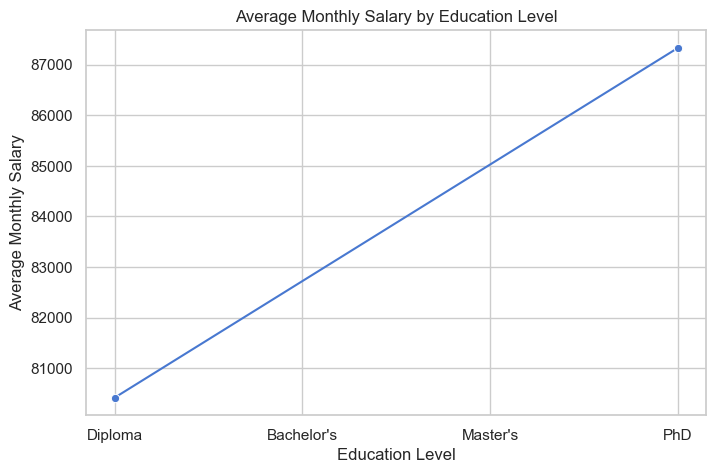

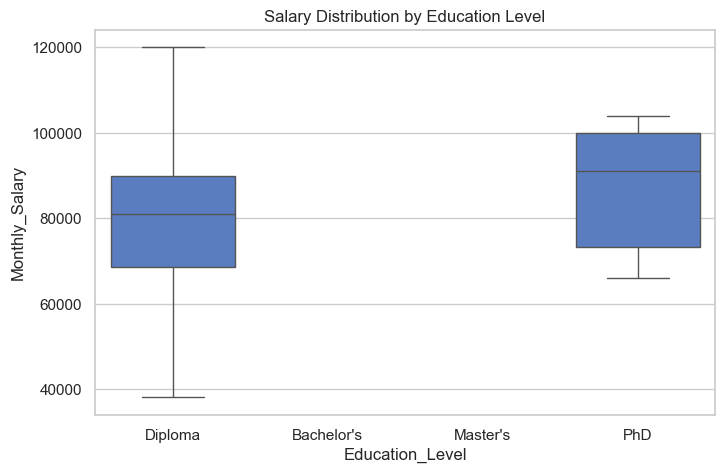

In [11]:
if 'Education_Level' in df.columns and 'Monthly_Salary' in df.columns:
    avg_salary_edu = df.groupby('Education_Level')['Monthly_Salary'].mean().reindex(edu_order)
    plt.figure(figsize=(8,5))
    sns.lineplot(x=avg_salary_edu.index, y=avg_salary_edu.values, marker='o')
    plt.title('Average Monthly Salary by Education Level')
    plt.xlabel('Education Level')
    plt.ylabel('Average Monthly Salary')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    sns.boxplot(x='Education_Level', y='Monthly_Salary', data=df)
    plt.title('Salary Distribution by Education Level')
    plt.show()
else:
    print('Education_Level or Monthly_Salary column missing')

## Work experience vs salary

Scatter plot and Pearson correlation.

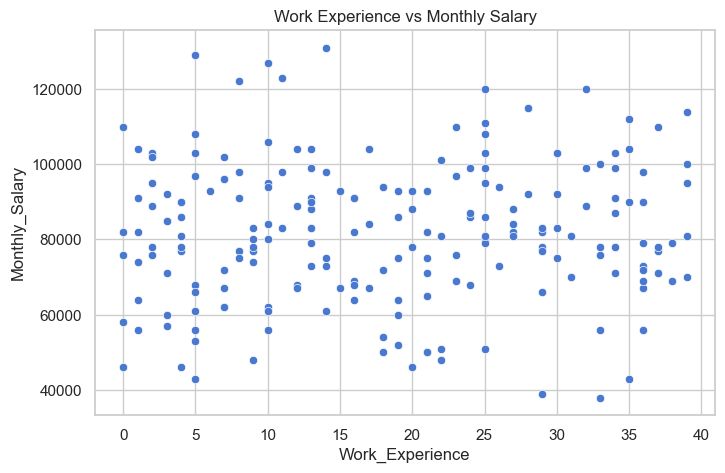

Pearson r = 0.047


In [12]:
if 'Work_Experience' in df.columns and 'Monthly_Salary' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='Work_Experience', y='Monthly_Salary', data=df)
    plt.title('Work Experience vs Monthly Salary')
    plt.show()
    corr = df['Work_Experience'].corr(df['Monthly_Salary'])
    print('Pearson r =', round(corr,3))
else:
    print('Work_Experience or Monthly_Salary column missing')

## Gender impact on salary

Compare average salaries and run t-test if two groups.

In [13]:
if 'Gender' in df.columns and 'Monthly_Salary' in df.columns:
    avg_gender = df.groupby('Gender')['Monthly_Salary'].agg(['count','mean','median','std'])
    display(avg_gender)
    unique_genders = df['Gender'].dropna().unique()
    if len(unique_genders)==2:
        g1 = df[df['Gender']==unique_genders[0]]['Monthly_Salary'].dropna()
        g2 = df[df['Gender']==unique_genders[1]]['Monthly_Salary'].dropna()
        tstat, pval = stats.ttest_ind(g1, g2, equal_var=False)
        print('T-test: t=',round(tstat,3),' p=',round(pval,4))
else:
    print('Gender or Monthly_Salary column missing')

,count,mean,median,std
Gender,,,,
Female,92,83239.130435,82500.0,18135.854576
Male,96,79229.166667,78000.0,19115.427314
Other,12,90833.333333,89500.0,15543.682337


## Department remote-work proportion

Identify department with highest proportion of remote workers (if column present).

In [14]:
remote_col = next((c for c in df.columns if 'remote' in c.lower()), None)
if remote_col:
    df['is_remote'] = df[remote_col].astype(str).str.lower().map(lambda x: 1 if x in ['yes','true','1','y','remote'] else 0)
    prop = df.groupby('Department')['is_remote'].mean().sort_values(ascending=False)
    display(prop)
    print('\nTop remote department:', prop.idxmax())
else:
    print('No remote-work column found')

Department
Finance       0.0
HR            0.0
IT            0.0
Marketing     0.0
Operations    0.0
Name: is_remote, dtype: float64


Top remote department: Finance


## ANOVA tests (statsmodels OLS)

Run one-way ANOVA for Work Experience (binned) and Education Level, and two-way ANOVA for interaction.

In [15]:
bins = [-1,2,5,10,100]
labels = ['0-2','3-5','6-10','10+']
if 'Work_Experience' in df.columns:
    df['WorkExpBin'] = pd.cut(df['Work_Experience'], bins=bins, labels=labels)

if 'WorkExpBin' in df.columns:
    model_exp = ols('Monthly_Salary ~ C(WorkExpBin)', data=df).fit()
    display(sm.stats.anova_lm(model_exp, typ=2))

if 'Education_Level' in df.columns:
    model_edu = ols('Monthly_Salary ~ C(Education_Level)', data=df).fit()
    display(sm.stats.anova_lm(model_edu, typ=2))

if 'WorkExpBin' in df.columns and 'Education_Level' in df.columns:
    model_int = ols('Monthly_Salary ~ C(Education_Level)*C(WorkExpBin)', data=df).fit()
    display(sm.stats.anova_lm(model_int, typ=2))
else:
    print('Missing columns for two-way ANOVA')

,sum_sq,df,F,PR(>F)
C(WorkExpBin),5.043755e+08,3.0,0.48035,0.696318
Residual,6.860104e+10,196.0,NaN,NaN


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Education_Level),1.345732e+09,3.0,1.503282,0.225587
Residual,1.581513e+10,53.0,NaN,NaN


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 2
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Education_Level),NaN,3.0,NaN,NaN
C(WorkExpBin),NaN,3.0,NaN,NaN
C(Education_Level):C(WorkExpBin),1.112128e+09,9.0,0.393129,0.677095
Residual,1.508754e+10,48.0,NaN,NaN


## OLS Regression: key predictors

Fit a simple OLS regression with numeric predictors and categorical factors to identify key factors influencing salary.

In [16]:
model_df = df.copy()
predictors = []
for c in ['Work_Experience','Performance_Score','Age','Education_Level_Code']:
    if c in model_df.columns:
        predictors.append(c)
if 'Department' in model_df.columns:
    top_depts = model_df['Department'].value_counts().nlargest(5).index.tolist()
    model_df['Department_top'] = model_df['Department'].where(model_df['Department'].isin(top_depts), 'Other')
    predictors.append('C(Department_top)')

formula = 'Monthly_Salary ~ ' + ' + '.join(predictors)
print('Formula:', formula)
try:
    reg = ols(formula, data=model_df.dropna(subset=['Monthly_Salary'] + [p for p in predictors if not p.startswith('C(')])).fit()
    print(reg.summary())
except Exception as e:
    print('Regression failed:', e)

Formula: Monthly_Salary ~ Work_Experience + Performance_Score + Age + C(Department_top)
                            OLS Regression Results                            
Dep. Variable:         Monthly_Salary   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.528
Date:                Fri, 31 Oct 2025   Prob (F-statistic):              0.160
Time:                        10:59:17   Log-Likelihood:                -2244.4
No. Observations:                 200   AIC:                             4505.
Df Residuals:                     192   BIC:                             4531.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------

## Practice: Predictive model (Linear Regression)

A basic regression using numeric features to predict Monthly_Salary. This is a simple baseline model for practice.

In [17]:
ml_df = df_encoded.copy()
if 'Monthly_Salary' in ml_df.columns:
    X = ml_df.select_dtypes(include=[np.number]).drop(columns=['Monthly_Salary'], errors='ignore')
    y = ml_df['Monthly_Salary']
    X = X.loc[:, X.columns.str.contains('Education_Level_Code|Work_Experience|Performance_Score|Age|Department_top')]
    if X.shape[1] == 0:
        X = ml_df.select_dtypes(include=[np.number]).drop(columns=['Monthly_Salary'], errors='ignore').iloc[:,:5]
    X = X.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    print('RMSE:', mean_squared_error(y_test, preds, squared=False))
    print('R2:', r2_score(y_test, preds))
else:
    print('Monthly_Salary not in data for ML practice')

TypeError: got an unexpected keyword argument 'squared'

## Save cleaned dataset and outputs

Save a cleaned CSV and model summary for inclusion in the repo outputs/ folder.

In [18]:
out_dir = '/mnt/data/analysis_outputs'
import os
os.makedirs(out_dir, exist_ok=True)
clean_path = os.path.join(out_dir, 'employee_cleaned.csv')
df.to_csv(clean_path, index=False)
print('Cleaned dataset saved to', clean_path)

try:
    anova_path = os.path.join(out_dir, 'anova_results.txt')
    with open(anova_path, 'w') as f:
        if 'model_exp' in globals():
            f.write(str(sm.stats.anova_lm(model_exp, typ=2)))
        if 'model_edu' in globals():
            f.write('\n\n')
            f.write(str(sm.stats.anova_lm(model_edu, typ=2)))
    print('ANOVA results saved to', anova_path)
except Exception as e:
    print('Failed to save ANOVA results:', e)

Cleaned dataset saved to /mnt/data/analysis_outputs\employee_cleaned.csv
ANOVA results saved to /mnt/data/analysis_outputs\anova_results.txt


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
